In [1]:
#Set-up
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
from IPython.display import clear_output
import nibabel as nib

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data as utils
import time
import copy

In [2]:
x = torch.load("/data/3d/ixi-data.pt")
y = torch.load("/data/3d/ixi-labels.pt")
n = x.shape[0]
y = torch.reshape(y,(n,1))
print(x.shape,y.shape)
print(x.dtype,y.dtype)

torch.Size([536, 3, 224, 224]) torch.Size([536, 1])
torch.float32 torch.float32


In [3]:
fcp_x = torch.load("/data/3d/fcp-data.pt")
fcp_y = torch.load("/data/3d/fcp-labels.pt").float()
n = fcp_x.shape[0]
fcp_y = torch.reshape(fcp_y,(n,1))
print(fcp_x.shape,fcp_y.shape)
print(fcp_x.dtype,fcp_y.dtype)

torch.Size([1033, 3, 224, 224]) torch.Size([1033, 1])
torch.float32 torch.float32


In [4]:
adni_x = torch.load('/data/3d/adni-data.pt')
adni_y = torch.load('/data/3d/adni-labels.pt').float()
adni_y = torch.reshape(adni_y, (adni_y.shape[0], 1))
print(adni_x.shape, adni_y.shape)
print(adni_x.dtype, adni_y.dtype)

torch.Size([570, 3, 224, 224]) torch.Size([570, 1])
torch.float32 torch.float32


In [5]:
#Normalizing the data (according to the stats provided) before feeding into the pretrained model
# fcp_x_normalized = torch.Tensor(fcp_x.shape)
# for i in range(n):
#     fcp_x_normalized[i] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]).__call__(fcp_x[i,:,:])


In [6]:
x = torch.cat((x, fcp_x, adni_x))
y = torch.cat((y, fcp_y, adni_y))
print(x.dtype, y.dtype)

torch.float32 torch.float32


In [7]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [8]:
dataset = utils.TensorDataset(x, y)
n = x.shape[0]
print('Total Data:', n)

Total Data: 2139


In [9]:
train_indices = [i for i in range(n) if (i % 5 == 0 or i % 5 == 2 or i % 5 == 4)]
val_indices = [i for i in range(n) if i % 5 == 3]
test_indices = [i for i in range(n) if i not in train_indices and i not in val_indices]

print('Training Data:', len(train_indices))
print('Validation Data:', len(val_indices))
print('Test Data:', len(test_indices))

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(train_indices),num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(val_indices),num_workers=4)

Training Data: 1283
Validation Data: 428
Test Data: 428


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss_history = []
    val_loss_history = []
    train_age_diff_history = []
    val_age_diff_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_offset = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_offset = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_offset += torch.sum(torch.abs(outputs - labels.data))

            epoch_loss = running_loss / n
            epoch_offset = running_offset / n

            print('{} Loss: {:.4f} Diff: {:.4f}'.format(
                phase, epoch_loss, epoch_offset))
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_age_diff_history.append(epoch_offset)
            else:
                train_loss_history.append(epoch_loss)
                train_age_diff_history.append(epoch_offset)
                
                

            # deep copy the model
            if phase == 'val' and epoch_offset < best_offset:
                best_offset = epoch_offset
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Diff: {:4f}'.format(best_offset))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_age_diff_history, val_age_diff_history

In [11]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft, train_loss_history, val_loss_history, train_age_diff_history, val_age_diff_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 291.2053 Diff: 10.0438
val Loss: 42.5569 Diff: 2.1036

Epoch 1/9
----------
train Loss: 106.7312 Diff: 6.0767
val Loss: 23.1901 Diff: 1.5274

Epoch 2/9
----------
train Loss: 93.4354 Diff: 5.6459
val Loss: 34.7237 Diff: 2.0322

Epoch 3/9
----------
train Loss: 80.5710 Diff: 5.1596
val Loss: 22.9217 Diff: 1.4855

Epoch 4/9
----------
train Loss: 73.5191 Diff: 4.8557
val Loss: 21.5214 Diff: 1.4093

Epoch 5/9
----------
train Loss: 68.1287 Diff: 4.6612
val Loss: 22.4774 Diff: 1.6321

Epoch 6/9
----------
train Loss: 51.0667 Diff: 4.0017
val Loss: 20.1064 Diff: 1.3985

Epoch 7/9
----------
train Loss: 43.8494 Diff: 3.6901
val Loss: 18.2611 Diff: 1.3515

Epoch 8/9
----------
train Loss: 40.7087 Diff: 3.5194
val Loss: 26.3815 Diff: 1.6634

Epoch 9/9
----------
train Loss: 39.2988 Diff: 3.4693
val Loss: 16.9299 Diff: 1.2940

Training complete in 3m 26s
Best val Diff: 1.293991


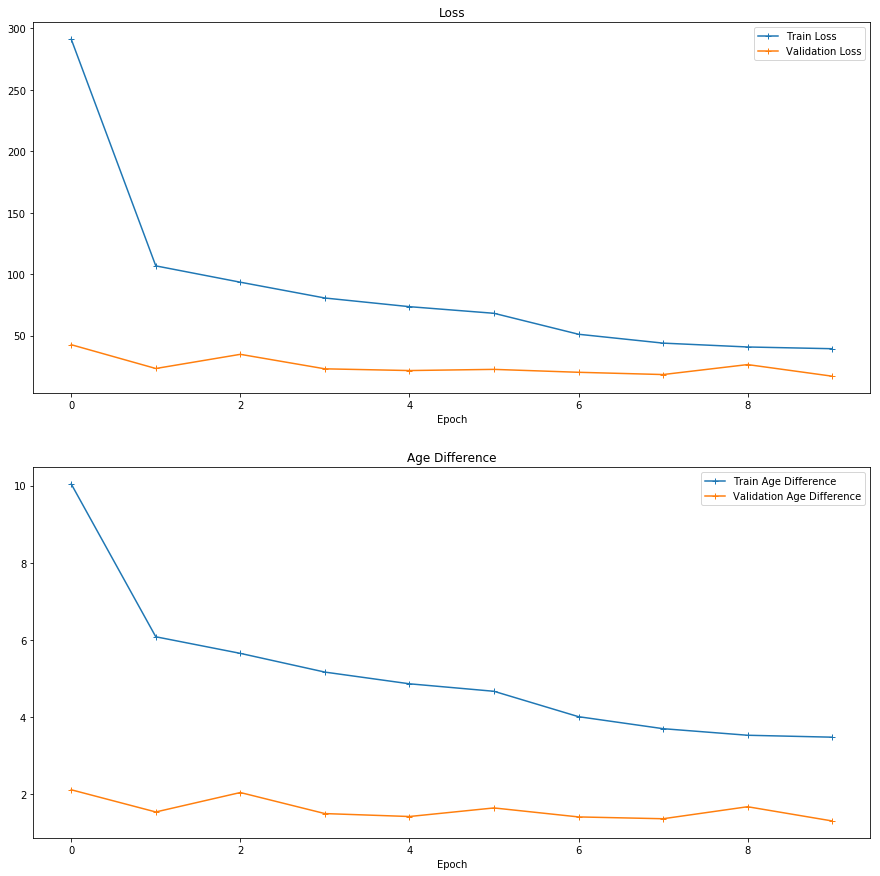

In [13]:
epochs = np.arange(10)
plt.subplot(2,1,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(epochs, train_loss_history, marker='+', label='Train Loss')
plt.plot(epochs, val_loss_history, marker='+', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.title('Age Difference')
plt.xlabel('Epoch')
plt.plot(epochs, train_age_diff_history, marker='+', label='Train Age Difference')
plt.plot(epochs, val_age_diff_history, marker='+', label='Validation Age Difference')
plt.legend(loc='upper right')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [14]:
def check_error(data,labels,model):
    print('Checking error on test set')   
    total_abs_err = 0.0
    num_samples = labels.shape[0]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        data = data.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        labels = labels.to(device=device,dtype=dtype)
        scores = model(data)
        predicted_ages = scores
        total_abs_err += (torch.abs(labels - scores).sum())
        mean_abs_err = float(total_abs_err) / num_samples
        print('Got error %.2f' % (mean_abs_err))

In [15]:
check_error(x[test_indices,:], y[test_indices],model_ft)

Checking error on test set
Got error 6.69


### Test on AD subjects

In [16]:
x_ad = torch.load("/data/3d/adni-ad-data.pt")
y_ad = torch.load("/data/3d/adni-ad-labels.pt")

In [17]:
data = x_ad.to(device=device, dtype=dtype)
labels = y_ad.to(device=device,dtype=dtype)

In [18]:
y_pred = model_ft(data)

In [36]:
labels[100]

tensor(67., device='cuda:0')

In [37]:
y_pred[236]

tensor([71.9790], device='cuda:0', grad_fn=<SelectBackward>)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


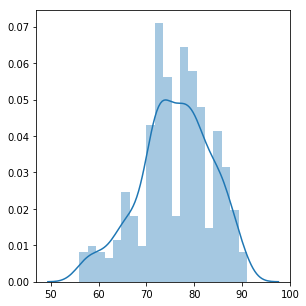

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


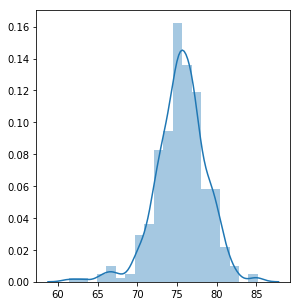

In [55]:
import seaborn as sns
def plot_age_distribution(data_frame, plot_place):
    plt.figure(figsize=(10,5))
    plt.subplot(plot_place)
    sns.distplot(data_frame, bins=20, label='Number of Subjects')
    plt.show()

plot_age_distribution(labels.cpu().detach().numpy(), 121)
plot_age_distribution(y_pred.cpu().detach().numpy(), 122)